# **Import Library**
Import library Python yang diperlukan dalam mengerjakan modul praktikum pada bagian ini.

In [43]:
## code
import numpy as np
import pandas as pd
import kagglehub
import sklearn
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#silahkan ditambahkan sesuai keperluan

# **Data Preparation**



## **Muat Data**
Unduh dataset yang digunakan dari kaggle dan muat menjadi dataframe menggunakan pandas.

Link Dataset:
- [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?utm_source=chatgpt.com)

Context:
*   This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Content:
*   The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.


In [5]:
# Lengkapi kode berikut
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/diabetes.csv")

Path to dataset files: C:\Users\barak\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Tampilkan 5 baris pertama dengan function head.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## **Exploratory Data Analysis**
Lakukan eksplorasi sederhana secara statistik pada dataset, beberapa fungsi yang krusial untuk digunakan:
* describe
* info
* correlation

Jelaskan hasil deskripsi data pada notebook!

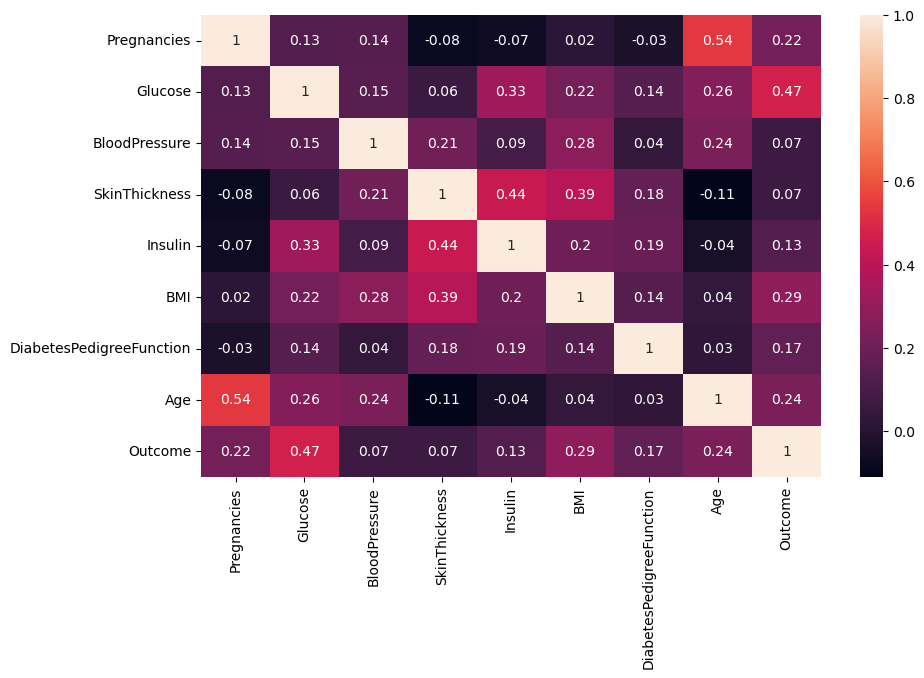

In [14]:
## Contoh correlation
plt.figure(figsize=(10, 6))
sns.heatmap(round(df.corr(),2), annot = True)
plt.show()

### **Lakukan Minimal 2 Data Visualization**
Data Visualization digunakan untuk meningkatkan pemahaman anda terhadap fitur-fitur penting, identifikasi anomali, dan menentukan metode data cleaning yang tepat terhadap dataset. Jelaskan hasil data visualization pada notebook!

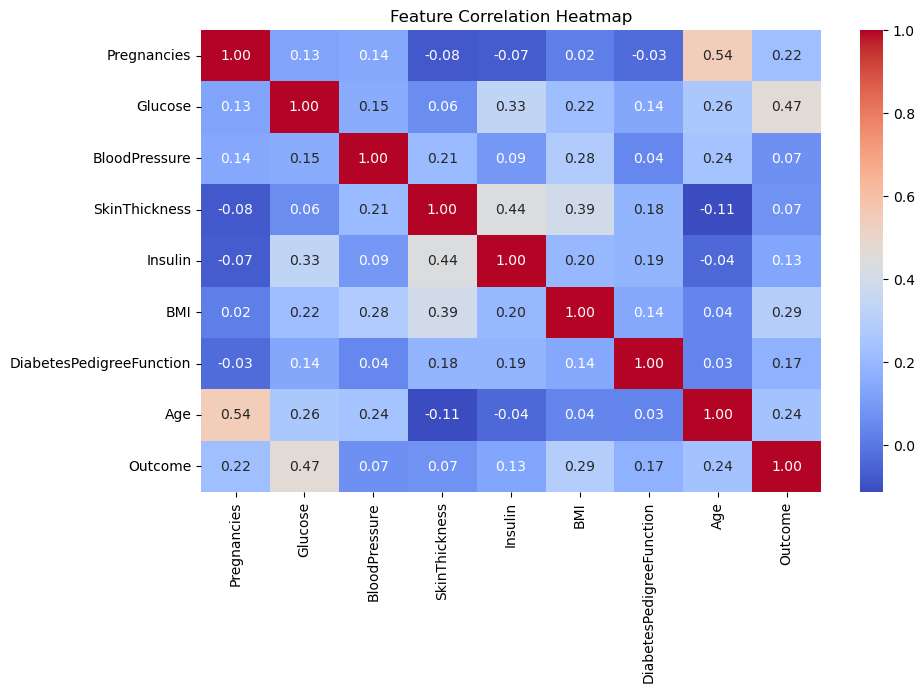

In [15]:
# Kode
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

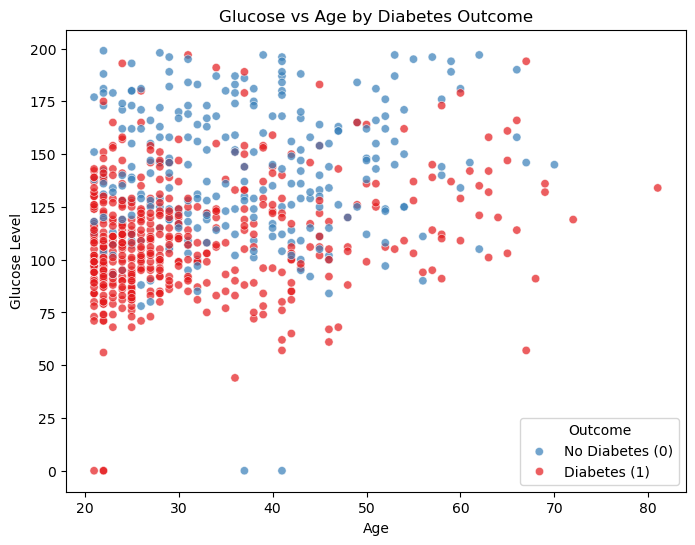

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='Glucose', hue='Outcome', palette='Set1', alpha=0.7)
plt.title('Glucose vs Age by Diabetes Outcome')
plt.xlabel('Age')
plt.ylabel('Glucose Level')
plt.legend(title='Outcome', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

#  **Data Splitting**
Lakukan data splitting ke dalam tiga bagian, yakni data latih (training set), data validasi (validation set), dan data uji (test set).

In [81]:
# === 1. SPLIT DATA ===
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split lagi untuk validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,  # 60/20/20 total
    random_state=42,
    stratify=y_train
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (460, 8)
Validation: (154, 8)
Test: (154, 8)


In [82]:
# === 2. HANDLE ZERO VALUES ===
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

X_train[cols_with_zero] = X_train[cols_with_zero].replace(0, np.nan)
X_val[cols_with_zero]   = X_val[cols_with_zero].replace(0, np.nan)
X_test[cols_with_zero]  = X_test[cols_with_zero].replace(0, np.nan)

imputer = SimpleImputer(strategy='median')
X_train[cols_with_zero] = imputer.fit_transform(X_train[cols_with_zero])
X_val[cols_with_zero]   = imputer.transform(X_val[cols_with_zero])
X_test[cols_with_zero]  = imputer.transform(X_test[cols_with_zero])

# **Preprocessing**

Lakukan proses preprocessing yang dibutuhkan untuk menyiapkan data agar bisa diproses machine learning, seperti feature scaling, encoding, dll.

In [83]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Konversi ke DataFrame agar bisa dilacak kolomnya
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled   = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# **Pemodelan**

Lakukan pelatihan model pada training set dengan evaluasi pada validation set. Gunakan kriteria berikut:
- Latih Model dan lakukan hyperparamater tuning pada tiga model berikut:
    - Decision Tree
    - Random Forest
    - XGBoost
- Evaluasi pelatihan model dengan minimal **empat metrik** yakni:
    - Akurasi
    - Precision
    - Recall
    - F1-Score
- Bandingkan performa model yang dilatih dan pilih salah satu model terbaik.
- Model yang dipilih wajib memiliki minimal akurasi sebesar **75%**.

In [84]:
# --- Decision Tree ---
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_dt,
    cv=5,
    scoring='accuracy'
)
grid_dt.fit(X_train_scaled, y_train)
best_dt = grid_dt.best_estimator_

y_val_pred_dt = best_dt.predict(X_val_scaled)
acc_dt = accuracy_score(y_val, y_val_pred_dt)
prec_dt = precision_score(y_val, y_val_pred_dt)
rec_dt = recall_score(y_val, y_val_pred_dt)
f1_dt = f1_score(y_val, y_val_pred_dt)

print("=== Decision Tree ===")
print(grid_dt.best_params_, f"| Acc: {acc_dt:.4f}, F1: {f1_dt:.4f}")

# --- Random Forest ---
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_rf,
    cv=5,
    scoring='accuracy'
)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

y_val_pred_rf = best_rf.predict(X_val_scaled)
acc_rf = accuracy_score(y_val, y_val_pred_rf)
prec_rf = precision_score(y_val, y_val_pred_rf)
rec_rf = recall_score(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf)

print("=== Random Forest ===")
print(grid_rf.best_params_, f"| Acc: {acc_rf:.4f}, F1: {f1_rf:.4f}")

# --- XGBoost ---
param_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_xgb,
    cv=5,
    scoring='accuracy'
)
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_

y_val_pred_xgb = best_xgb.predict(X_val_scaled)
acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
prec_xgb = precision_score(y_val, y_val_pred_xgb)
rec_xgb = recall_score(y_val, y_val_pred_xgb)
f1_xgb = f1_score(y_val, y_val_pred_xgb)

print("=== XGBoost ===")
print(grid_xgb.best_params_, f"| Acc: {acc_xgb:.4f}, F1: {f1_xgb:.4f}")

=== Decision Tree ===
{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2} | Acc: 0.7792, F1: 0.6047
=== Random Forest ===
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200} | Acc: 0.7792, F1: 0.6531
=== XGBoost ===
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | Acc: 0.7532, F1: 0.6415


In [86]:
# === 5. RANGKUMAN HASIL ===
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_dt, acc_rf, acc_xgb],
    'Precision': [prec_dt, prec_rf, prec_xgb],
    'Recall': [rec_dt, rec_rf, rec_xgb],
    'F1-Score': [f1_dt, f1_rf, f1_xgb]
})

print("\n=== Perbandingan Model ===")
print(results.sort_values(by='Accuracy', ascending=False))


=== Perbandingan Model ===
           Model  Accuracy  Precision    Recall  F1-Score
0  Decision Tree  0.779221   0.812500  0.481481  0.604651
1  Random Forest  0.779221   0.727273  0.592593  0.653061
2        XGBoost  0.753247   0.653846  0.629630  0.641509


# **Final Model**

Lakukan pelatihan ulang model akhir pada kombinasi training dan validation set, lalu evaluasi pada test set. Model akhir ini pastikan memiliki performa yang tidak turun drastis dengan minimal akurasi **70%**.

C:\Users\barak\anaconda3\envs\scatest\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



=== Final Model Evaluation (Test Set) ===
Akurasi   : 0.7532
Precision : 0.6538
Recall    : 0.6296
F1-Score  : 0.6415

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



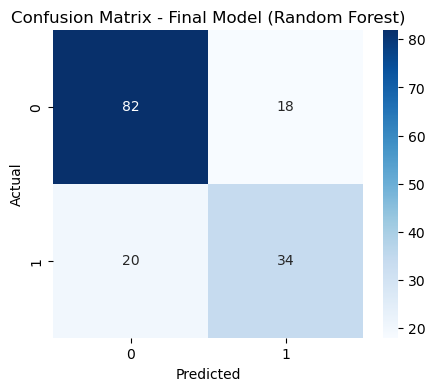

In [87]:
# === 6. FINAL MODELING ===

# Gabungkan data training dan validation (yang sudah diskalakan)
X_final_train = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)

# Gunakan parameter terbaik dari Random Forest
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Latih ulang pada seluruh data training
final_model.fit(X_final_train, y_final_train)

# Evaluasi di test set (yang sudah diskalakan juga!)
y_test_pred = final_model.predict(X_test_scaled)

# === 7. METRIK AKHIR ===
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("\n=== Final Model Evaluation (Test Set) ===")
print(f"Akurasi   : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Model (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()